In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [2]:
### Takes lists of r and omega values and outputs r e^(i omega)
def gen(inp):
    return np.array([i[0]*np.exp(1j*i[1]) for i in inp])

### Convolves an arbitrary number of polynomial coefficients. 
### It takes in a series locations of zeroes/poles and evaluates the coefficients of the polynomial, ie:
### (z-p_1)(z-p_2)(z-p_3)...(z-p_n) 
def convolve_list(a):
    conv = np.array([1])
    for i in a:
        conv=np.convolve(conv,[1,-i])
    return np.round(conv,10)

### Evaluates the transfer fucntion at various values of omega
def transfer(zero_coeffs,pole_coeffs,w):
    numerator=sum([zero_coeffs[i]*np.exp(i*1j*w) for i in range(len(zero_coeffs))])
    denominator=sum([pole_coeffs[i]*np.exp(i*1j*w) for i in range(len(pole_coeffs))])
    return numerator/denominator

### Plots the poles and zeroes in the complex plane
### Also plots the amplitude and phase of H(w)
def pole_zero(zeroes,poles,rate):
    fig, ax = plt.subplots(1, 3,figsize=(12,4))
    
    ax[0].scatter(zeroes.real,zeroes.imag,s=60,facecolors="none",edgecolors="b")
    ax[0].scatter(poles.real,poles.imag,s=60,marker="x",c="r")
    x=np.linspace(-1,1,1000,endpoint=True)
    ax[0].plot(x,np.sqrt(1-x**2),"--",c="k")
    ax[0].plot(x,-np.sqrt(1-x**2),"--",c="k")
    ax[0].tick_params(labelsize=14)
    ax[0].set_xlabel("Real",fontsize=16)
    ax[0].set_ylabel("Imaginary",fontsize=16)
    #ax[0].set_axis('equal')
    
    zero_coeffs = convolve_list(zeroes)
    pole_coeffs = convolve_list(poles)
    
    nums = [transfer(zero_coeffs,pole_coeffs,w) for w in np.linspace(0,np.pi,10000)]
    
    ax[1].plot(rate*np.linspace(0,np.pi,10000)/(2*np.pi),np.abs(nums))
    ax[1].tick_params(labelsize=14)
    ax[1].set_xlabel("Frequency (Hz)",fontsize=16)
    ax[1].set_ylabel("Amplitude",fontsize=16)
    ax[1].set_xlim(0,rate/2)
    
    ax[2].plot(rate*np.linspace(0,np.pi,10000)/(2*np.pi),np.angle(nums))
    ax[2].tick_params(labelsize=14)
    ax[2].set_xlabel("Frequency (Hz)",fontsize=16)
    ax[2].set_ylabel("Phase (rad)",fontsize=16)
    ax[2].set_xlim(0,rate/2)
    plt.tight_layout()

### Plots the response of a signal to a single pulse. Must be stable for the filter to work!
def resp_to_pulse(a,b,num=50):
    x_dict={-i:0 for i in range(1,len(a)+3)}
    y_dict={-i:0 for i in range(1,len(b)+3)}
    x_dict[0]=1
    
    for i in range(num):
        total = 0
        for j in range(len(a)):
            total+=a[j]*x_dict[i-j]           
        for j in range(1,len(b)):
            total+=-b[j]*y_dict[i-j]
            
        y_dict[i]=total
        x_dict[i+1]=0
    fig=plt.figure(figsize=(9,5))
    for x, y in y_dict.items():
        if x>=0:
            plt.scatter(x,y.real,facecolors="none",edgecolors="b")
    plt.xlim(-1,num)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlabel("n",fontsize=16)
    plt.ylabel("amplitude",fontsize=16)
    plt.tight_layout()
    #plt.title("Stability of signal")

### Computes the response to an arbitrary input signal
def resp_to_signal(a,b,signal,num):
    x_dict={-i:0 for i in range(1,len(a)+3)}
    y_dict={-i:0 for i in range(1,len(b)+3)}

    for i in range(num):
        total = 0
        x_dict[i]=signal[i]
        for j in range(len(a)):
            total+=a[j]*x_dict[i-j]
            
        for j in range(1,len(b)):
            total+=-b[j]*y_dict[i-j]
            
        y_dict[i]=total

    output = [y_dict[i].real for i in range(num)] 
    return output      

    
### Plots time and frequency domain of signals
def plot_sig(seq):
    fig, ax = plt.subplots(1, 2,figsize=(12,4))
    ax[0].tick_params(labelsize=14)
    ax[0].plot(seq[:500])
    ax[0].set_xlabel("t",fontsize=16)
    ax[0].set_ylabel("amplitude",fontsize=16)
    ft = abs(np.fft.fft(seq))[:int(rate/2)]
    ax[1].tick_params(labelsize=14)
    ax[1].plot(ft/max(ft))
    ax[1].set_xlim(0,rate/2)
    ax[1].set_xlabel("frequency",fontsize=16)
    ax[1].set_ylabel("normalized amplitude",fontsize=16)
    plt.tight_layout()

The transfer function of a filter is:
$$H(z) = \frac{(z-q_1)(z-q_2)...(z-q_n)}{(z-p_1)(z-p_2)...(z-p_m)}$$

Where $z_i$ are the zeroes of the function and $p_j$ are the poles. The transfer function is high near poles and low near zeroes.

First, we will create a signal.

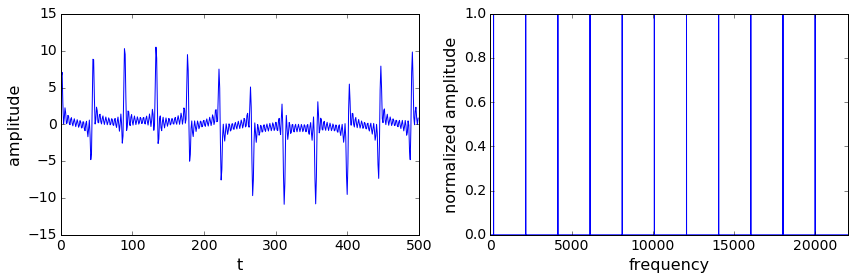

In [3]:
rate = 44100 # sample rate
duration = 2.0    # seconds
signal = np.zeros(int(rate*duration))
for i in range(len(signal)):
    for j in np.linspace(100,10000,11,endpoint=True):
        signal[i] += np.sin(2*np.pi*i*j/rate)

plot_sig(signal)
ipd.Audio(signal, rate=rate)

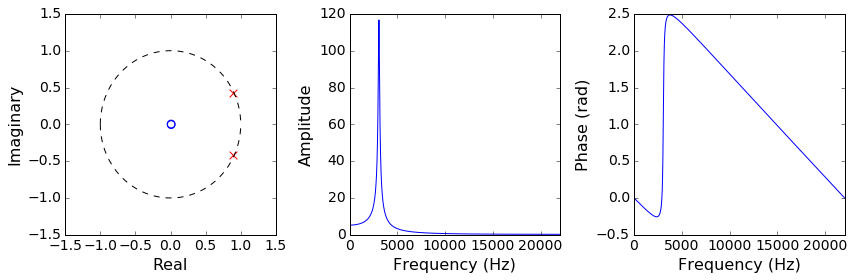

In [4]:
### Input as many zeroes and poles (in polar form) as you wish, in the form [(r_1,omega_1),(r_2,omega_2)...]
### NOTE: If you are inputting complex numbers (omega not 0 or pi), 
### include the complex conjugate (negative angle) as an additional entry

### Try with this filter first

zeroes = gen([(0.01,2*np.pi*3070/rate),(0.01,-2*np.pi*3070/rate)])
poles = gen([(0.99,2*np.pi*3070/rate),(0.99,-2*np.pi*3070/rate)])

### THEN UNCOMMENT AND RUN THIS ONE. THE FIRST IS STABLE, THIS ISN'T
### HAVING POLES WITH r>1 LEADS TO EXPONENTIALLY EXPLOSIVE SOLUTIONS
#zeroes = gen([(1,np.pi/3),(1,-np.pi/3),(1,np.pi/7),(1,-np.pi/7)])
#poles = gen([(0.9,np.pi/3),(0.9,-np.pi/3),(1.1,np.pi/7),(1.1,-np.pi/7)])

pole_zero(zeroes,poles,rate)

Next, we must test the filter's stability by injecting it with a single pulse.

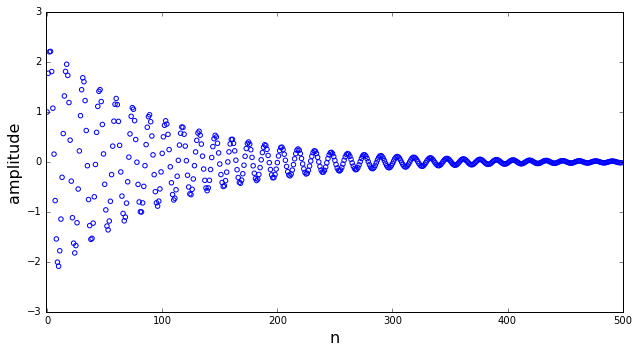

In [5]:
zero_coeffs = convolve_list(zeroes)
pole_coeffs = convolve_list(poles)
resp_to_pulse(zero_coeffs,pole_coeffs,num=500)

Now, we can apply the constructed filter to the input signal.

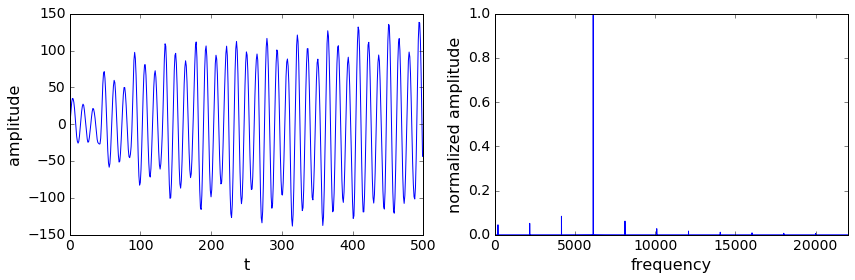

In [6]:
output = resp_to_signal(zero_coeffs,pole_coeffs,signal,int(rate*duration))
plot_sig(output)
ipd.Audio(output, rate=rate)